### 6. Курсовой проект "Создание чат-бота в Telegram"
**Задание**
Реализовать сценарии поведения для диалоговой системы<br>
1. сценарий болталка
2. покупка товара
3. погода в городе по запросу

In [ ]:
!pip freeze

absl-py==1.4.0
aiohttp==3.9.1
aiosignal==1.3.1
alabaster==0.7.13
albumentations==1.3.1
altair==4.2.2
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array-record==0.5.0
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.0
attrs==23.1.0
audioread==3.0.1
autograd==1.6.2
Babel==2.13.1
backcall==0.2.0
beautifulsoup4==4.11.2
bidict==0.22.1
bigframes==0.15.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.1
bqplot==0.12.42
branca==0.7.0
build==1.0.3
CacheControl==0.13.1
cachetools==5.3.2
catalogue==2.0.10
certifi==2023.11.17
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.7
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==2.2.1
cmake==3.27.7
cmdstanpy==1.2.0
colorcet==3.0.1
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.4
cons==0.4.6
contextlib2==21.6.0
contourpy==1.2.0
cryptography==41.0.7
cufflinks==0.17.3
cupy-cuda11x==11.0.0
cvxopt==1.3.2
cvxpy==1.3.2
cycler==0.12.1
c

In [ ]:
!pip install telegram

  Preparing metadata (setup.py) ... done
  Created wheel for telegram: filename=telegram-0.0.1-py3-none-any.whl size=1293 sha256=309421f82b4c387c8964b32b6d00f0c9ef697a16b29da4c381b63e911c0c7a72
  Stored in directory: /root/.cache/pip/wheels/f3/f2/16/dc6d6c6c7e0422206fec62833039a2b4082de3b85e55d32b52
Successfully built telegram


In [ ]:
!pip install pymorphy2
!pip install stop_words
!pip install annoy
!pip install pandarallel
!pip install python-telegram-bot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 56.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=48d4b6d7592677e829cf07c0e1982b665f643a510dd01e46843e6e9e1bb1d2c0
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
  Preparing metadata (setup.py) ... done
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32895 sha256=4d2cb09a8d3ae391ce4cab26f339123dd1655f58ef6f01815f7bcbb6ff056664
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop_words
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-c

In [ ]:
import os
from telegram.ext import Updater, CommandHandler, MessageHandler, filters
import string
from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
import annoy
from gensim.models import Word2Vec, FastText
import pickle
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import pickle

tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
import mmap
import re

def get_num_lines(file_path):
    fp = open(file_path, "r+")
    buf = mmap.mmap(fp.fileno(), 0)
    lines = 0
    while buf.readline():
        lines += 1
    return lines

In [ ]:
from google.colab import files

In [ ]:
uploaded = files.upload()

In [ ]:
# Преобразование файла вопросов-ответов в строчный вид
if not os.path.isfile('prepared_answers.txt'):

    question = None
    written = False

    with open("prepared_answers.txt", "w") as fout:
        with open("Otvety.txt", "r") as fin:
            for line in tqdm_notebook(fin):
                if line.startswith("---"):
                    written = False
                    continue
                if not written and question is not None:
                    fout.write(question.replace("\t", " ").strip() + "\t" + line.replace("\t", " "))
                    written = True
                    question = None
                    continue
                if not written:
                    question = line.strip()
                    continue

In [ ]:
data = pd.read_csv("Otvety.txt")
data.head()

In [ ]:
# Препроцессинг текста
def preprocess_txt(line):
    spls = "".join(i for i in line.strip() if i not in exclude).split()
    spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
    spls = [i for i in spls if i not in sw and i != ""]
    return spls

In [ ]:
# Функция для очистки текста из статьи https://habr.com/ru/articles/738176/ адаптированная под русский язык
def clean_text(input_text):

    # HTML-теги: первый шаг - удалить из входного текста все HTML-теги
    clean_text = re.sub('<[^<]+?>', '', input_text)

    # URL и ссылки: далее - удаляем из текста все URL и ссылки
    clean_text = re.sub(r'http\S+', '', clean_text)

    #Эмоджи и эмотиконы: используем собственную функцию для преобразования эмоджи в текст
    #Важно понимать эмоциональную окраску обрабатываемого текста
    clean_text = emojis_words(clean_text)

    # Приводим все входные данные к нижнему регистру
    clean_text = clean_text.lower()

    # Убираем все пробелы
    # Так как все данные теперь представлены словами - удалим пробелы
    clean_text = re.sub('\s+', ' ', clean_text)

    #Убираем специальные символы: избавляемся от всего, что не является "словами"
    clean_text = re.sub('[^а-яА-ЯёЁ0-9\s]', '', clean_text) #

    # Записываем числа прописью: 100 превращается в "сто" (для компьютера)# не работает
    temp = inflect.engine()
    words = []
    for word in clean_text.split():
        if word.isdigit():
            words.append(num2words(int(word), lang='ru'))
        else:
            words.append(word)
    clean_text = ' '.join(words)

        # Стоп-слова: удаление стоп-слов - это стандартная практика очистки текстов
    stop_words = set(stopwords.words('russian'))
    tokens = word_tokenize(clean_text)
    tokens = [token for token in tokens if token not in stop_words]
    clean_text = ' '.join(tokens)

    # Знаки препинания: далее - удаляем из текста все знаки препинания
    clean_text = re.sub(r'[^\w\s]', '', clean_text)

    # И наконец - возвращаем очищенный текст
    return clean_text

# Функция для преобразования эмоджи в слова
def emojis_words(text):

    # Модуль emoji: преобразование эмоджи в их словесные описания
    clean_text = emoji.demojize(text, delimiters=(" ", " "))

    # Редактирование текста путём замены ":" и" _", а так же - путём добавления пробела между отдельными словами
    clean_text = clean_text.replace(":", "").replace("_", " ")

    return clean_text

def preproc_text(text):
    res = str(text).strip()
    res = re.sub(r"\s+", " ", res)
    return res

def build_data(data_q, data_ans):
    data = []
    for idx, texts in enumerate(data_q):
        question = preproc_text(texts)
        answer = preproc_text(data_ans.iloc[idx])
        res = '\nx:' + question + '\ny:' + answer
        data.append(res)
    return data

In [ ]:
!pip install pymorphy3

In [ ]:
# Обработка текста
from pymorphy3 import MorphAnalyzer

sentences = []
morpher = MorphAnalyzer()
sw = set(get_stop_words("ru"))
exclude = set(string.punctuation)
c = 0

file_path_from = 'prepared_answers.txt'
file_path_to = 'Otvety2.txt'

if not os.path.isfile(file_path_to):

    N = get_num_lines(file_path_from)
    with open(file_path_to, mode = 'w') as fileto:
        with open(file_path_from) as filefrom:
            for k in tqdm(range(N)):
                line = filefrom.readline()
                if line == '': break
                spls = preprocess_txt(line)
                sentences.append(spls)
                c += 1
                if c > 500000000:
                    break
                fileto.write(' '.join(spls)+'\n')
    filefrom.close()
    fileto.close()

In [ ]:
# Загрузим результат

sentences = []

file_path_from = 'Otvety2.txt'
if os.path.isfile(file_path_from):
    N = get_num_lines(file_path_from)
    with open(file_path_to, mode = 'r') as filefrom:
        for k in tqdm(range(N)):
            line = filefrom.readline()
            if line == '': break
            sentences.append(line.split())
    filefrom.close()

In [ ]:
vec = []
_ = [vec.extend(x)  for x in sentences[:100]]
vec = list(set(vec))
vec.sort()
vec[20:30]

In [ ]:
sentences[:10]

Обучим модель FastText

In [ ]:
file_path_from = 'ft_model'
if not os.path.isfile(file_path_from):

    sentences = [i for i in tqdm(sentences) if len(i) > 2]
    modelFT = FastText(sentences=sentences, size=100, min_count=1, window=5)
    modelFT.save("ft_model")

In [ ]:
modelFT = FastText.load("ft_model")
ft_index = annoy.AnnoyIndex(100 ,'angular')

In [ ]:
list(set(get_stop_words("ru")))[:20]

Индексы для вопросов-ответов

In [ ]:
file_path_from = 'speaker.ann'
if not os.path.isfile(file_path_from):
    morpher = MorphAnalyzer()
    sw = set(get_stop_words("ru"))
    exclude = set(string.punctuation)
    modelFT = FastText.load("ft_model")
    ft_index = annoy.AnnoyIndex(100 ,'angular')

    index_map = {}
    counter = 0
    with open("Otvety2.txt", "r") as f:
        for line in tqdm(f):
            n_ft = 0
            spls = line.split("\t")
            index_map[counter] = spls[1]
            question = preprocess_txt(spls[0])
            vector_ft = np.zeros(100)
            for word in question:
                if word in modelFT.wv:
                    vector_ft += modelFT.wv[word]
                    n_ft += 1
            if n_ft > 0:
                vector_ft = vector_ft / n_ft
            ft_index.add_item(counter, vector_ft)

            counter += 1

            if counter > 50_000:
                break

    ft_index.build(10)
    ft_index.save('speaker.ann')

    with open("index_speaker.pkl", "wb") as f:
        pickle.dump(index_map, f)

In [ ]:
#Загрузим индексы
ft_index = annoy.AnnoyIndex(100, 'angular')
ft_index.load('speaker.ann')
index_map = pd.read_pickle("index_speaker.pkl")

In [ ]:
np.random.permutation(100)

In [ ]:
a = ft_index.get_nns_by_vector(np.random.permutation(100), 5, include_distances=True)
a

In [ ]:
[index_map[x] for x in a[0]]

Модель продуктовых данных

In [ ]:
uploaded = files.upload()

In [ ]:
shop_data = pd.read_csv("ProductsDataset.csv")

shop_data['text'] = shop_data['title'] + " " + shop_data["descrirption"]
shop_data['text'] = shop_data['text'].progress_apply(lambda x: preprocess_txt(str(x)))
shop_data.head()

In [ ]:
#Векторизация
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = CountVectorizer(ngram_range=(1, 2))

In [ ]:
idxs = set(np.random.randint(0, len(index_map), len(shop_data)))
# Вопрос-ответный домен
negative_texts = [" ".join(preprocess_txt(index_map[i])) for i in tqdm(idxs)]
# Продуктовый домен
positive_texts = [" ".join(val) for val in tqdm(shop_data['text'].values)]

In [ ]:
#разбивка на положительный/отрицательный
dataset = negative_texts + positive_texts
labels = np.zeros(len(dataset))
labels[len(negative_texts):] = np.ones(len(positive_texts))

In [ ]:
#сплитуем на трейн  и тест
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2,
                                                    stratify=labels, random_state=13)

Обучим простую модель Логистической регрессии

In [ ]:
x_train_vec = vectorizer.fit_transform(X_train)
x_test_vec = vectorizer.transform(X_test)

lr = LogisticRegression().fit(x_train_vec, y_train)

In [ ]:
#проверим метрики точности и Tfidf-веса
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
accuracy_score(y_true=y_test, y_pred=lr.predict(x_test_vec))

In [ ]:
tfidf_vect = TfidfVectorizer().fit(X_train)
np.mean(tfidf_vect.idf_)

In [ ]:
idfs = {v[0]: v[1] for v in zip(tfidf_vect.vocabulary_, tfidf_vect.idf_)}
list(idfs.keys())[:10]

In [ ]:
list(idfs.values())[:10]

Индексы для данных по товарам

In [ ]:
file_path_from = 'shop.ann'
if not os.path.isfile(file_path_from):


    ft_index_shop = annoy.AnnoyIndex(100 ,'angular')

    midf = np.mean(tfidf_vect.idf_)

    index_map_shop = {}
    counter = 0

    for i in tqdm(range(len(shop_data))):
        n_ft = 0
        index_map_shop[counter] = (shop_data.loc[i, "title"], shop_data.loc[i, "image_links"])
        vector_ft = np.zeros(100)
        for word in shop_data.loc[i, "text"]:
            if word in modelFT.wv:
                vector_ft += modelFT.wv[word] * idfs.get(word, midf)
                n_ft += idfs.get(word, midf)
        if n_ft > 0:
            vector_ft = vector_ft / n_ft
        ft_index_shop.add_item(counter, vector_ft)
        counter += 1

    ft_index_shop.build(10)
    ft_index_shop.save('shop.ann')

    file_path_from = 'index_shop.pkl'
    if not os.path.isfile(file_path_from):

        with open("index_shop.pkl", "wb") as f:
            pickle.dump(index_map_shop, f)


In [ ]:
#Загрузим индексы
midf = np.mean(tfidf_vect.idf_)

ft_index_shop = annoy.AnnoyIndex(100, 'angular')
ft_index_shop.load('shop.ann')

index_map_shop = pd.read_pickle("index_shop.pkl")

In [ ]:
#Функция векторизации текста
def embed_txt(txt, idfs, midf):
    n_ft = 0
    vector_ft = np.zeros(100)
    for word in txt:
        if word in modelFT.wv:
            vector_ft += modelFT.wv[word] * idfs.get(word, midf)
            n_ft += idfs.get(word, midf)
    return vector_ft / n_ft

In [ ]:
ft_index_shop.get_nns_by_vector(np.ones(100)*20, 5, include_distances=True)

Создание бота в телеграмм

In [ ]:

updater = Updater("6838788278:AAEe3f2qu7f9tJNGvkDY2-iXbD46lln539I", use_context=True) # Токен API к Telegram
dispatcher = updater.dispatcher

def startCommand(update, context):
    context.bot.send_message(chat_id=update.message.chat_id, text='Привет.')

def textMessage(update, context):

    input_txt = preprocess_txt(update.message.text)
    vect = vectorizer.transform([" ".join(input_txt)])
    prediction = lr.predict(vect)


    if prediction[0] == 1:
        vect_ft = embed_txt(input_txt, idfs, midf)
        ft_index_shop_val = ft_index_shop.get_nns_by_vector(vect_ft, 5)
        for item in ft_index_shop_val:
            title, image = index_map_shop[item]
            context.bot.send_message(chat_id=update.message.chat_id, text="title: {} image: {}".format(title, image))
        return

    #Товары
    vect_ft = embed_txt(input_txt, {}, 1)
    ft_index_val, distances = ft_index.get_nns_by_vector(vect_ft, 1, include_distances=True)


    if distances[0] > 100.5:
        print(distances[0])
        context.bot.send_message(chat_id=update.message.chat_id, text="Моя твоя не понимать")
        return

    # Вопрос-Ответ
    context.bot.send_message(chat_id=update.message.chat_id, text=index_map[ft_index_val[0]])

start_command_handler = CommandHandler('start', startCommand)
text_message_handler = MessageHandler(Filters.text, textMessage)
dispatcher.add_handler(start_command_handler)
dispatcher.add_handler(text_message_handler)
updater.start_polling(clean=True)
updater.idle()

In [ ]:
#Настройки
from telegram.ext  import Updater, CommandHandler, MessageHandler, filters, CallbackContext
import dialogflow
import logging

updater = Updater(token='6838788278:AAEe3f2qu7f9tJNGvkDY2-iXbD46lln539I') # Токен API к Telegram
dispatcher = updater.dispatcher

In [ ]:
def startCommand(bot, update):
    bot.send_message(chat_id=update.message.chat_id, text='Привет')

def textMessage(bot, update):
    response = 'Ваше сообщение принял ' + update.message.text # формируем текст ответа
    bot.send_message(chat_id=update.message.chat_id, text=response)

logging.basicConfig(
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.INFO
)

logger = logging.getLogger()

def start(update: Update, context: CallbackContext):
    update.message.reply_text('Привет!')

def echo(update: Update, context: CallbackContext):
    txt = update.message.text

    update.message.reply_text('Ваше сообщение! ' + update.message.text)

updater = Updater("6838788278:AAEe3f2qu7f9tJNGvkDY2-iXbD46lln539I", use_context=True)
dispatcher = updater.dispatcher

# команды для ответа в Telegram
dispatcher.add_handler(CommandHandler("start", start))
dispatcher.add_handler(MessageHandler(Filters.text & ~Filters.command, echo))

# запуск бота
updater.start_polling()
updater.idle()

'''Создаём папку Bot, в которой потом создаём файл bot.py.
Вы можете создать просто текстовый блокнот и вместо расширения .txt напишите .py
Собираем код нашего бота. Открываем консоль и переходим в директорию с файлом,
 и запускаем python3 bot.py Бот будет работать пока будет открыто окно консоли.'''

Напишем своего Telegram-бота для получения данных о погоде в любом городе нашей планеты. Мы детально рассмотрим работу с API, парсинг JSON и напишем бота на асинхронной библиотеке aiogram. А после — загрузим его на виртуальный сервер и запустим.

Перед написанием кода нужно получить API-токены для работы с сервисом OpenWeather и Telegram-ботом, а также подготовить рабочее окружение.

Получаем токен OpenWeather После того, как вы создали API-ключ, дайте ему немного «отлежаться» — обычно это занимает 10-15 минут. Спустя это время можно общаться с OpenWeather с помощью сгенерированного токена.

In [1]:
!pip install --force-reinstall -v "aiogram==2.23.1"

Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 119.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.5/162.5 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.1/142.1 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.6/301.6 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.5/502.5 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.9 MB/s eta 0:00:00
  Attempting uninstal

In [2]:
import os
import datetime
import requests

from aiogram import Bot, types, Dispatcher
from aiogram import executor
bot = Bot(token='6627542051:AAEZjRDntQfeS6KaoSaz2GozGxSFDIFpHLs')
dp = Dispatcher(bot)

In [3]:
!pip install config
!pip install nest-asyncio

In [6]:
import asyncio
import logging

#from aiogram import CommandStart, Command

import config


Создание бота

Для начала проверим, что aiogram увидел бота и мы можем с ним взаимодействовать. Создадим простую асинхронную функцию start_command для ответа на команду /start. И добавляем метод start_polling для запуска бота.

In [7]:
import nest_asyncio
nest_asyncio.apply()
bot = Bot(token='6627542051:AAEZjRDntQfeS6KaoSaz2GozGxSFDIFpHLs')
dp = Dispatcher(bot)

@dp.message_handler(commands="start")
async def start_command(message: types.Message):
    await message.reply("Привет! Напиши мне название города и я пришлю сводку погоды")


if __name__ == "__main__":
#С помощью метода executor.start_polling опрашиваем
#Dispatcher: ожидаем команду /start
    executor.start_polling(dp)

Запускаем скрипт, заходим в Telegram и пишем команду /start — все работает: бот возвращает нужное сообщение.

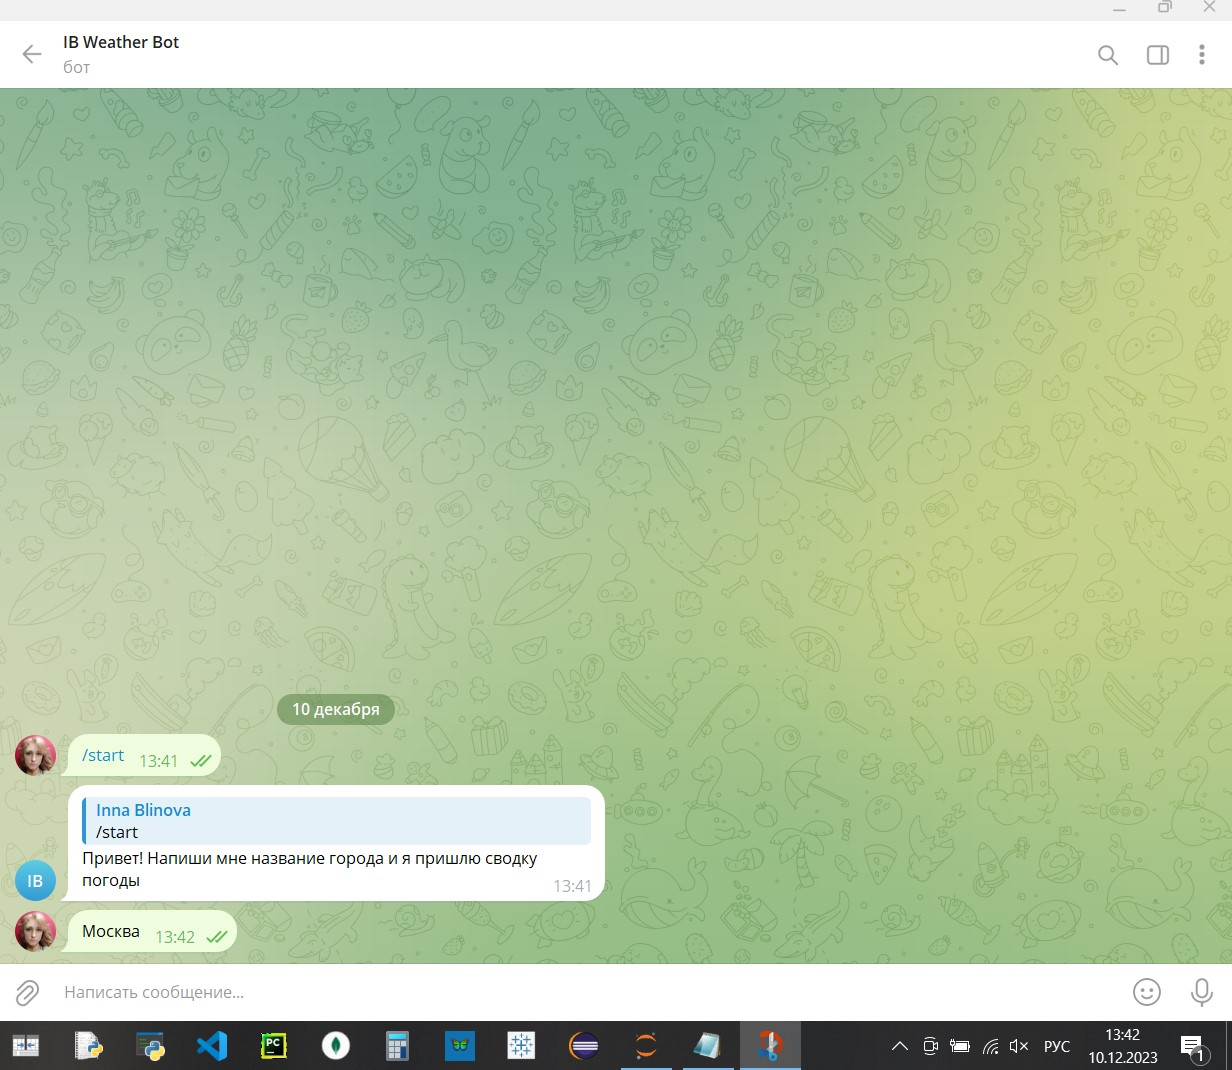

Теперь добавим функцию, которая будет реагировать на текстовые сообщения с названиями городов. Она должна проверять их на корректность и выводить ошибку, если валидация не была пройдена.

In [8]:
@dp.message_handler()
async def get_weather(message: types.Message):
    pass

#OpenWeather должен принимать название города через API и возвращать данные о погоде.
#Исходя из документации, кроме названия города запрос должен содержать API-токен.

Усовершенствуем запрос: в параметр q будем передавать город, добавим параметр lang=ru, чтобы API работал с кириллицей. А также используем units=metric для установки метрической системы:

In [ ]:
https://api.openweathermap.org/data/2.5/weather?q=москва&lang=ru&units=metric&APPID=f85fe01557bb38e5506a3007b7fe9fb8

In [ ]:
#Теперь добавим блок try-except для обработки пользовательских запросов и
#создадим переменную для записи результатов OpenWeather, которые возвращает сервис в JSON-формате.

@dp.message_handler()
async def get_weather(message: types.Message):
    try:
response = requests.get(
f"https://api.openweathermap.org/data/2.5/weather?q=москва&lang=ru&units=metric&APPID=f85fe01557bb38e5506a3007b7fe9fb8"
)
data = response.json()
except:
    await message.reply("Проверьте название города!")

Отправим запрос через браузер и посмотрим, какая температура, например, в Москве.

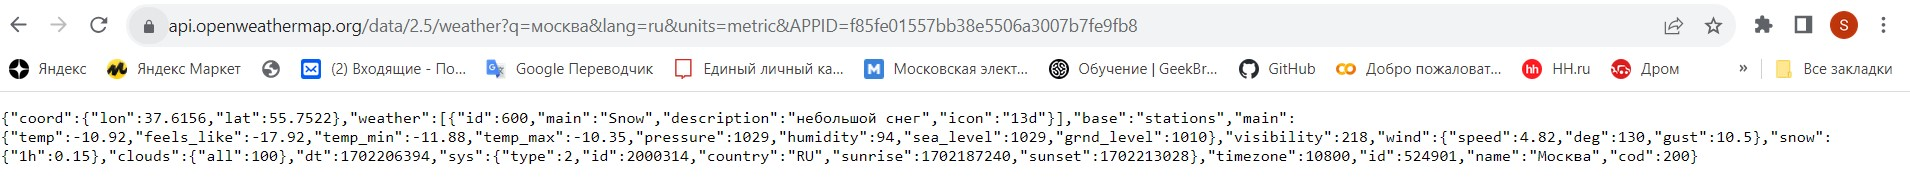

В ответе получаем не только данные о температуре, но и облачность, давление, влажность, время заката, рассвета и другие величины.

заберем данные о городе и температуре, влажности, давлении и скорости ветра

In [ ]:

city = data["name"]
cur_temp = data["main"]["temp"]
humidity = data["main"]["humidity"]
pressure = data["main"]["pressure"]
wind = data["wind"]["speed"]

In [ ]:
# получаем время рассвета и преобразуем его в читабельный формат
sunrise_timestamp = datetime.datetime.fromtimestamp(data["sys"]["sunrise"])

# то же самое проделаем со временем заката
sunset_timestamp = datetime.datetime.fromtimestamp(data["sys"]["sunset"])

Зная время рассвета и заката, мы можем вернуть пользователю продолжительность дня

In [ ]:
@dp.message_handler()
async def get_weather(message: types.Message):
  try:
response = requests.get(
f"http://api.openweathermap.org/data/2.5/weather?q=москва&lang=ru&units=metric&APPID=f85fe01557bb38e5506a3007b7fe9fb8"
)
data = response.json()
city = data["name"]
cur_temp = data["main"]["temp"]
humidity = data["main"]["humidity"]
pressure = data["main"]["pressure"]
wind = data["wind"]["speed"]

sunrise_timestamp = datetime.datetime.fromtimestamp(data["sys"]["sunrise"])
sunset_timestamp = datetime.datetime.fromtimestamp(data["sys"]["sunset"])

# продолжительность дня
length_of_the_day = datetime.datetime.fromtimestamp(data["sys"]["sunset"]) - datetime.datetime.fromtimestamp(data["sys"]["sunrise"])

except:
  await message.reply("Проверьте название города!")

Разнообразим текст сообщений — будем выводить разные эмодзи в зависимости от погоды.

У словаря, который мы ранее спарсили, есть ключ main — он хранит описание погоды. На его основе мы можем создать свою коллекцию с эмодзи под разные ситуации.

In [ ]:
code_to_smile = {
"Clear": "Ясно \U00002600",
"Clouds": "Облачно \U00002601",
"Rain": "Дождь \U00002614",
"Drizzle": "Дождь \U00002614",
"Thunderstorm": "Гроза \U000026A1",
"Snow": "Снег \U0001F328",
"Mist": "Туман \U0001F32B"
}

In [ ]:
#в случае специфической погоды, для которой эмодзи не предусмотрен, программа выводит специальное сообщение
#получаем значение погоды
weather_description = data["weather"][0]["main"]

if weather_description in code_to_smile:
    wd = code_to_smile[weather_description]
else:
# если эмодзи для погоды нет, выводим другое сообщение
    wd = "Посмотри в окно, я не понимаю, что там за погода..."

Сформируем строки с датой и временем, погодой, влажностью и другими данными. Главное — учесть формат данных. Например, OpenWeather возвращает значение давления в гектопаскалях. Так, если вы хотите отдавать пользователю данные в миллиметрах ртутного столба, значение нужно разделить на 1.33 и округлить в большую сторону.

In [ ]:
await message.reply(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M')}"\n
     f"Погода в городе: {city}\nТемпература: {cur_weather}°C {wd}\n"
     f"Влажность: {humidity}%\nДавление: {math.ceil(pressure/1.333)} мм.рт.ст\nВетер: {wind} м/с \n"
     f"Восход солнца: {sunrise_timestamp}\nЗакат солнца: {sunset_timestamp}\nПродолжительность дня: {length_of_the_day}\n"
     f"Хорошего дня!"
)
#бот работает и возвращает данные в удобочитаемом формате